# **Data analysis: cooperative strategies**

This notebook contains the necessary code to analyze both the reward data per episode, obtained from the logs, and the performance metrics of the multipliers with an error of less than or equal to 10%, obtained with OpenLane. The modularization of the code addresses the common requirements for both analyses, such as the libraries used, and the preprocessing of the data separately depending on which data is desired to be visualized.

## Importing libraries

In [1]:
import os
import glob
import re
import pandas as pd
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


def convertir_a_minutos(tiempo_str: str) -> float:
    """Convierte '0h1m21s0ms' a minutos decimales."""
    pattern = r'(?:(\d+)h)?(?:(\d+)m)?(?:(\d+)s)?(?:(\d+)ms)?'
    m = re.match(pattern, tiempo_str)
    if not m:
        return 0.0
    hs, ms, ss, mls = (int(m.group(i) or 0) for i in range(1, 5))
    return hs * 60 + ms + ss / 60 + mls / 60000

# LogAnalyzer Class

In [2]:
class LogAnalyzer:
    """
    Parsea recursivamente carpetas de logs, extrae:
      - raw_df: episodio a episodio
      - summary_df: por worker_id (métrica agregada)
      - summary: dict con vistas adicionales tipo Logs_<nombre>_Summary y Logs_<nombre>_WorkerSummary
    """

    _fname_rx = re.compile(r"log_\d{4}-\d{2}-\d{2}(?:_[^_]+)?_worker_(\d+)\.txt$")
    _line_rx  = re.compile(
        r"Episode\s+(\d+)\s+actualizó.*recompensa:\s*([-\d\.]+)\s*con error medio:([-\d\.]+)"
    )
    _time_fmt = "%Y-%m-%d %H:%M:%S,%f"

    def __init__(self, folders: list[str], nombre: str):
        self.folders   = folders
        self.nombre    = nombre
        self.log_files = self._gather_log_files()

        self.run_times: dict[int, tuple[datetime, datetime]] = {}
        self._raw_records: list[tuple[int,int,float,float]] = []

        self._parse_all_logs()

        # ▫️ Episodio a episodio
        self.raw_df = pd.DataFrame(
            self._raw_records,
            columns=["worker_id", "episode", "reward", "error_mean"]
        )

        # ▫️ Vista agregada por worker
        self.summary_df = self._aggregate_summary_df()

        # ▫️ Diccionario con vistas listas para Plotter
        self.summary = self._generate_named_views()

    
    def _gather_log_files(self) -> list[str]:
        base_path = Path.cwd()  # en notebook, es el directorio actual
        data_path = base_path

        files = []
        for base in self.folders:
            folder = data_path / base
            #print(folder)  # imprime la ruta
            pattern = str(folder / "**" / "log_*.txt")
            files.extend(glob.glob(pattern, recursive=True))
        return files

    def _parse_file(self, path: str):
        fn = os.path.basename(path)
        m0 = self._fname_rx.search(fn)
        if not m0:
            raise ValueError(f"Nombre inesperado: {path}")
        wid = int(m0.group(1))

        t0 = None
        tf = None
        local_recs = []

        with open(path, "r", encoding="utf-8") as f:
            for raw in f:
                ts_str = raw.split(" - ",1)[0]
                try:
                    ts = datetime.strptime(ts_str, self._time_fmt)
                    t0 = t0 or ts
                    tf = ts
                except:
                    pass

                m = self._line_rx.search(raw)
                if m:
                    ep  = int(m.group(1))
                    rw  = float(m.group(2))
                    err = float(m.group(3))
                    local_recs.append((wid, ep, rw, err))

        if t0 and tf:
            self.run_times[wid] = (t0, tf)

        self._raw_records.extend(local_recs)

    def _parse_all_logs(self):
        for path in self.log_files:
            self._parse_file(path)

    def _aggregate_summary_df(self) -> pd.DataFrame:
        if not self.raw_df.empty:
            grp = self.raw_df.groupby("worker_id",group_keys=False)
            df0 = pd.DataFrame({
                "update_count": grp["episode"].count(),
                "min_error": grp["error_mean"].min(),
                "episode_of_min_error": grp.apply(
                    lambda g: int(g.loc[g["error_mean"].idxmin(), "episode"].item()),include_groups=False
                )
            }).reset_index()
        else:
            df0 = pd.DataFrame(columns=[
                "worker_id", "update_count", "min_error", "episode_of_min_error"
            ])

        all_ids = sorted(self.run_times.keys())
        df0 = df0.set_index("worker_id").reindex(all_ids).reset_index()

        df0["update_count"] = df0["update_count"].fillna(0).astype(int)
        max_err = df0["min_error"].max(skipna=True)
        df0["min_error"] = df0["min_error"].fillna(max_err)

        df0["total_time_min"] = df0["worker_id"].map(
            lambda w: (self.run_times[w][1] - self.run_times[w][0]).total_seconds()/60
        )

        return df0[[
            "worker_id", "update_count", "min_error",
            "episode_of_min_error", "total_time_min"
        ]]

    def _generate_named_views(self) -> dict:
        named_views = {}

        # ▫️ Vista por episodio
        ep_df = self.raw_df[["episode", "error_mean"]].dropna().sort_values(by="episode").reset_index(drop=True)
        named_views[f"Logs_{self.nombre}_Summary"] = ep_df

        # ▫️ Vista agregada por worker
        named_views[f"Logs_{self.nombre}_WorkerSummary"] = self.summary_df

        return named_views


## OpenLaneAnalyzer Class

In [3]:
class OpenLaneAnalyzer:
    """
    Carga/combina CSVs, extrae 'error' y prepara:
      - raw_data: dataframes sin agrupar
      - grouped_data: dataframes agrupados por error
    """

    def __init__(self, folders: list[str], combined_name: str = "combined_metrics.csv"):
        self.folders = folders
        self.combined_name = combined_name
        #self.df = self._load_or_combine()
        #self._extract_error()
        self.raw_data: dict[str, pd.DataFrame] = {}
        self.grouped_data: dict[str, pd.DataFrame] = {}
        #self._prepare_all()

## Plotter Class

In [4]:
class Plotter:
    """
    Toma un OpenLaneAnalyzer y grafica líneas o dispersión.
    Cada traza es un dict con:
      - tipo: clave en analyzer.grouped_data/raw_data
      - x, y: nombres de columnas
      - color, label (opcional)
    """

    def __init__(self, analyzer: OpenLaneAnalyzer):
        self.raw = analyzer.raw_data
        self.grp = analyzer.grouped_data
        self.summary = {}
        sns.set(style="whitegrid")

    def plot_lines(
        self,
        traces: list[dict],
        title: str,
        xlabel: str,
        ylabel: str,
        name: str,
        log: bool,
        figsize: tuple[int, int] = (4, 3),
    ):
        fig=plt.figure(figsize=figsize)
        for t in traces:
            df = self.grp[t["tipo"]]
            #print(df)
            df= df.groupby('episode', as_index=False)['error_mean'].min()
            mask = df['error_mean'].cummin() == df['error_mean']
            # Aplicar la máscara para filtrar el DataFrame
            df= df[mask].reset_index(drop=True)
            if not log:
              plt.plot(
                  df[t["x"]], df[t["y"]],
                  marker="o",
                  color=t["color"],
                  label=t.get("label"),
              )
              x= df[t["x"]]
              label=t.get("label")
              #print(f"Longitud de {label}: " + str(len(x)))
            else:
              plt.semilogx(
                  df[t["x"]], df[t["y"]],
                  marker="o",
                  color=t["color"],
                  label=t.get("label"),
              )
              x= df[t["x"]]
              label=t.get("label")
              #print(f"Longitud de {label}: " + str(len(x)))
        if any(t.get("label") for t in traces):
            plt.legend()
        plt.title(title)
        plt.axhline(y=0.1, color='blue', linestyle='--', linewidth=1.2)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.tight_layout()
        plt.grid(True)
        plt.show()
        fig.savefig(name+".svg",format="svg")
        fig.savefig(name+".pdf", format="pdf")
        return self.grp
    def plot_scatter(
    self,
    traces: list[dict],
    title: str,
    xlabel: str,
    ylabel: str,
    figsize: tuple[int, int] = (4, 3),
):
      plt.figure(figsize=figsize)

      for t in traces:
          # Selecciona el DataFrame adecuado
          if t["tipo"] in self.grp:
              df = self.grp[t["tipo"]]
          else:
              df = self.raw[t["tipo"]]

          plt.scatter(
              df[t["x"]],
              df[t["y"]],
              color=t.get("color", "k"),
              marker=t.get("marker", "o"),
              label=t.get("label")
          )

      if any(t.get("label") for t in traces):
          plt.legend()

      plt.axhline(y=0.1, color='red', linestyle='--', linewidth=1.2)

      plt.title(title)
      plt.xlabel(xlabel)
      plt.ylabel(ylabel)
      plt.grid(True)
      plt.tight_layout()
      plt.show()


# **Main**

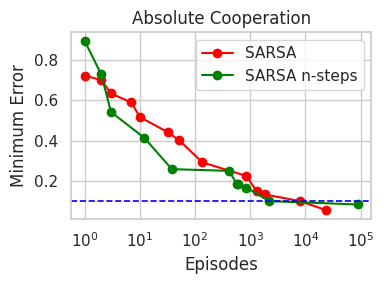

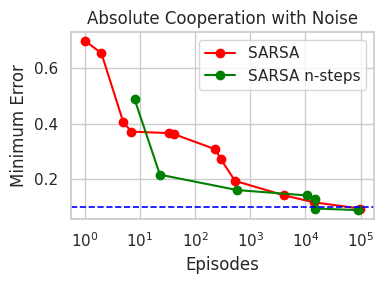

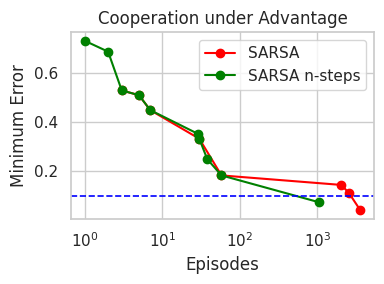

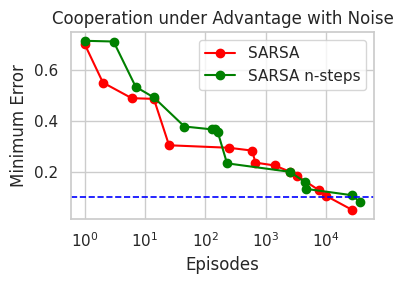

In [5]:
if __name__ == "__main__":
    # Define las carpetas donde buscar CSVs
    carpetas = [ #Insertar la ruta donde se encuentra el github
        "/home/sebastian/Documents/GitHub/Reinforcement-Learning-Enhanced-Design-Space-Exploration-for-Digital-Multipliers/"
    ]

    # Rutas de los logs
    log_folders_nada = [
        "Logs/Dependent Workers WITHOUT noise WITHOUT advantage/SARSA",
        "Logs/Dependent Workers WITHOUT noise WITHOUT advantage/SARSA n-steps"
    ]

    log_folders_ruido = [
        "Logs/Dependent Workers WITH noise WITHOUT advantage/SARSA",
        "Logs/Dependent Workers WITH noise WITHOUT advantage/SARSA n-steps"
    ]

    log_folders_ventaja = [
        "Logs/Dependent Workers WITHOUT noise WITH advantage/SARSA",
        "Logs/Dependent Workers WITHOUT noise WITH advantage/SARSA n-steps"
    ]


    log_folders_ventaja_ruido = [
        "Logs/Dependent Workers WITH noise WITH advantage/SARSA",
        "Logs/Dependent Workers WITH noise WITH advantage/SARSA n-steps"
    ]

    def GraficarLogs (log_folders, carpetas,name,titulo):

      analyzer = OpenLaneAnalyzer(carpetas)
      plotter = Plotter(analyzer)
      
      # Lista para trazas de episodios vs error
      trazas_ep_vs_err = []
      color_map = ["red", "green", "blue"]

      # Para cada carpeta de logs, creamos un LogAnalyzer y graficamos
      for i, ruta in enumerate(log_folders):
          # Obtener un nombre corto para etiquetas (último segmento de la ruta)
          nombre = os.path.basename(ruta)
          #print(f"nombre:{nombre}")
          log_analyzer = LogAnalyzer([ruta], nombre)
          #print(log_analyzer.log_files)
          plotter.raw[f"Logs_{nombre}"] = log_analyzer.raw_df
          
          # 1. Cargamos el DataFrame
          df = log_analyzer.summary[f'Logs_{nombre}_Summary']

          # 2. Filtramos solo los episodios distintos de 0 y reajustamos el índice
          df = df[df['episode'] != 0].reset_index(drop=True)

          # 3. Asignamos el resultado de vuelta
          log_analyzer.summary[f'Logs_{nombre}_Summary'] = df

          plotter.grp.update(log_analyzer.summary)
          plotter.summary.update(log_analyzer.summary)

        # Añadir traza a la lista para comparativa
          trazas_ep_vs_err.append({
              "tipo": f"Logs_{nombre}_Summary",
              "x": "episode",
              "y": "error_mean",
              "color": color_map[i % len(color_map)],
              "label": nombre
          })
      df=plotter.plot_lines(
        traces=trazas_ep_vs_err,
        title=titulo,
        xlabel="Episodes",
        ylabel="Minimum Error",
        log = True,
        name=name
      )
      return df

    Absolute_Cooperation=GraficarLogs(log_folders_nada, carpetas,name="graf_nada",titulo="Absolute Cooperation")
    Absolute_Cooperation_with_Noise=GraficarLogs(log_folders_ruido, carpetas,name="graf_ruido",titulo="Absolute Cooperation with Noise")
    Cooperation_under_Advantage=GraficarLogs(log_folders_ventaja, carpetas,name="graf_ventaja",titulo="Cooperation under Advantage")
    Cooperation_under_Advantage_with_Noise=GraficarLogs(log_folders_ventaja_ruido, carpetas,name="graf_ventaja_ruido",titulo="Cooperation under Advantage with Noise")

## Convergence metrics

In [ ]:
# ------------ CONFIGURACIÓN ------------
input=[Absolute_Cooperation, Absolute_Cooperation_with_Noise,
       Cooperation_under_Advantage, Cooperation_under_Advantage_with_Noise]

names=["Absolute_Cooperation", "Absolute_Cooperation_with_Noise",
       "Cooperation_under_Advantage", "Cooperation_under_Advantage_with_Noise"]

epsilon = 0.1   # Umbral para First Hitting Time
tail_frac = 0.1 # Último 10% de episodios para error final
# ---------------------------------------

metrics_list = []

for w, k in enumerate(input):          # cada escenario
    for i, j in enumerate(k.keys()):   # cada worker o estrategia
        if i % 2 == 0:  # filtra los índices pares como hacías tú
            df = k[j][["episode", "error_mean"]].reset_index(drop=True)

            # --- 1. First Hitting Time (FHT) ---
            fht = np.nan
            mask = df["error_mean"] <= epsilon
            if mask.any():
                fht = df.loc[mask, "episode"].iloc[0]  # primer episodio que cruza epsilon

            # --- 2. AUC discreta (suma trapecio normalizada) ---
            auc = np.trapezoid(df["error_mean"], df["episode"])
            auc_norm = auc / (df["episode"].iloc[-1] - df["episode"].iloc[0])

            # --- 3. Error Final (último 10%) ---
            tail_start = int(len(df) * (1 - tail_frac))
            error_final = df["error_mean"].iloc[tail_start:].mean()

            # --- 4. Mejoras Globales ---
            best_so_far = float("inf")
            improvements = 0
            for val in df["error_mean"]:
                if val < best_so_far:
                    improvements += 1
                    best_so_far = val

            # Guardar resultados
            metrics_list.append({
                "Scenario": names[w],
                "Worker": j,
                "FHT": fht,
                "AUC_norm": auc_norm,
                "Error_final": error_final,
                "Improvements": improvements
            })

# DataFrame con todas las métricas
df_metrics = pd.DataFrame(metrics_list)
df_metrics.head(10)

,Scenario,Worker,FHT,AUC_norm,Error_final,Improvements
0,Absolute_Cooperation,Logs_SARSA_Summary,8003,0.098895,0.077778,14
1,Absolute_Cooperation,Logs_SARSA n-steps_Summary,2214,0.093631,0.091667,11
2,Absolute_Cooperation_with_Noise,Logs_SARSA_Summary,98251,0.111384,0.105556,12
3,Absolute_Cooperation_with_Noise,Logs_SARSA n-steps_Summary,15149,0.101038,0.088889,7
4,Cooperation_under_Advantage,Logs_SARSA_Summary,3575,0.123981,0.116667,8
5,Cooperation_under_Advantage,Logs_SARSA n-steps_Summary,1053,0.159780,0.146528,11
6,Cooperation_under_Advantage_with_Noise,Logs_SARSA_Summary,27617,0.111693,0.077778,14
7,Cooperation_under_Advantage_with_Noise,Logs_SARSA n-steps_Summary,37137,0.127029,0.094444,15


In [ ]:
pd.set_option("display.max_rows", None)  # muestra todas las filas
df.shape

(18, 2)

In [ ]:
df=Cooperation_under_Advantage_with_Noise['Logs_SARSA_Summary']
mask = df['error_mean'].cummin() == df['error_mean']
# Aplicar la máscara para filtrar el DataFrame
df= df[mask].reset_index(drop=True)
print(df)

    episode  error_mean
0         1    0.700000
1         2    0.550000
2         6    0.488889
3        14    0.486111
4        25    0.304167
5       244    0.294444
6       597    0.283333
7       678    0.236111
8      1409    0.225000
9      2568    0.200000
10     3379    0.183333
11     7684    0.127778
12    10120    0.105556
13    27617    0.050000
